## Level 2: Lab 3

#### In this lab we will cover:

- Support Vector Machine, Softmax for image recognition
- Neural Networks with TensorFlow: Setting up Architecture and Loss
    - Architecture, activation functions
    - loss functions, weight initialization, 
    - batch normalization, regularization (L2/dropout)

In [66]:
import numpy as np
import os
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import ensemble
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import train_test_split

In [67]:
import tensorflow as tf
import pandas as pd

In [68]:
%matplotlib inline

In [69]:
import skimage

http://scikit-image.org/

In [ ]:
# import cv2

https://opencv.org/

#### 1. Support Vector Machine

Support Vector Machine is a supervised classification model (sometimes we also use Support Vector Regression for a regression problem). In short, the goal of SVM is to find a **classifier** in the feature space to classify the positive samples and negtive samples. 

###### How to use SVM in image classification?

To conduct an SVM over the image dataset, we need to extract features from the images first. 
Here are some common options to extract the features:
1. *Conduct a **PCA** over all the pixels*
2. *Scale-invariant feature transform ( **SIFT** )*
3. *Histogram of Oriented Gradient ( **HOG** )*

In the following example, we use *HOG* to classify the images in the ***Dogs v.s. Cats*** dataset.

Import the dataset.

https://www.kaggle.com/c/dogs-vs-cats/data

In [70]:
data_path="/Users/shahab/Documents/kaggle/dogs_vs_cats"
img_list = os.listdir(data_path+"/train/")
len(img_list)

25000

In [71]:
img_list[:10]

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg']

We have 25000 images. Their labels are shown in the file names. Now we define 'cat'=1 and 'dog'=0.

In [72]:
labels = [int(img.split('.')[0]=='cat') for img in img_list]
labels[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [85]:
cat_images = [mpimg.imread(data_path +'/train/'+ img) for img in img_list[:100]]
dog_images = [mpimg.imread(data_path +'/train/'+ img) for img in img_list[-100:]]

In [87]:
sample_images=cat_images+dog_images

In [86]:
labels_sample=labels[:100]+labels[-100:]

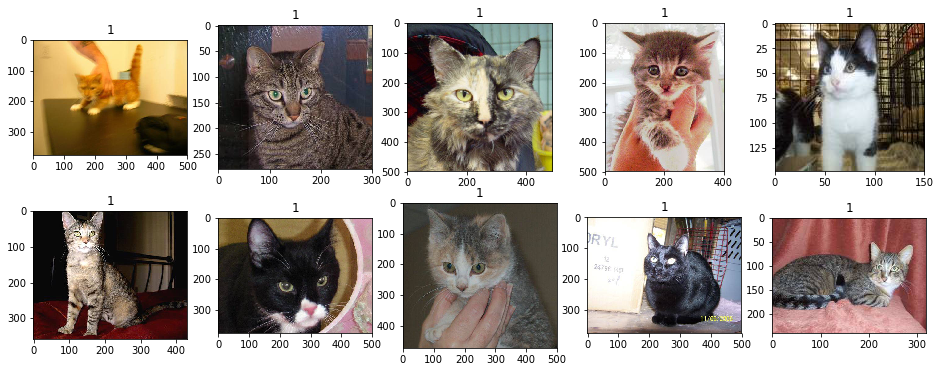

In [90]:
plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(cat_images[i])
    plt.title(labels_sample[i])
plt.show()

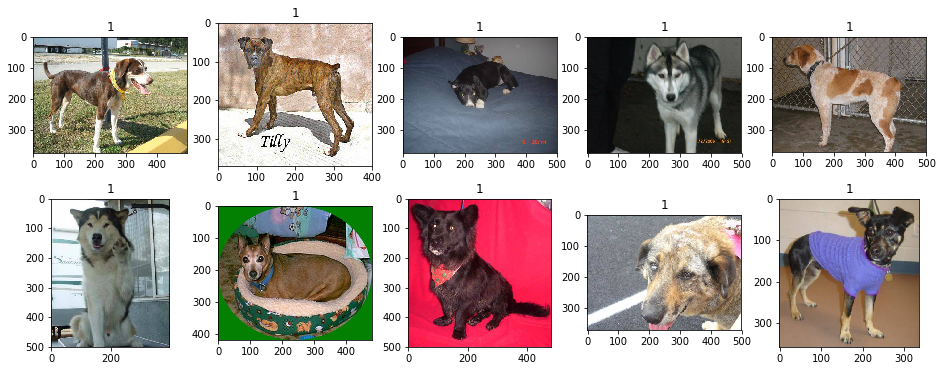

In [91]:
plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(dog_images[i])
    plt.title(labels_sample[i])
plt.show()

Since not every image is in the same size, let's resize those images.

In [75]:
from tqdm import tqdm

In [76]:
lbl2name={0:'dog',1:'cat'}
lbl2count={0:0,1:0}

In [92]:
RESIZED_IMAGES_AVAILABLE=os.path.exists(data_path+"/train_resized")

In [96]:
if not RESIZED_IMAGES_AVAILABLE:
    print("Resizing images...")
    resized_images = [skimage.transform.resize(img,(128,128)) for img in sample_images]
    print("done.")

Resizing images...


/Users/shahab/anaconda/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


done.


In [ ]:
if not RESIZED_IMAGES_AVAILABLE:
    os.makedirs(data_path+"/train_resized")
    print("Saving resized images...")
    #save resized images to save time for later runs
    file_path=data_path+"/train_resized/"
    for im,lbl in zip(resized_images,labels):
        file_name="%s.%d.jpg"%(lbl2name[lbl],lbl2count[lbl])
        mpimg.imsave(file_path+file_name, im, format="jpg")
        lbl2count[lbl]+=1
    print("Done.")

In [ ]:
if RESIZED_IMAGES_AVAILABLE:
    #read resized images
    print("Loading resized images...")
    file_path=data_path+"/train_resized/"
    img_list = os.listdir(file_path)
    resized_images_copy = []
    labels_copy=[]
    for img in tqdm(img_list):
        if not img.endswith("jpg"):
            continue
        resized_images_copy.append(mpimg.imread(file_path + img))
        labels_copy.append(int(img.split('.')[0]=='cat'))
    print("Done.")
    print("Number of images loaded:",len(resized_images_copy))

Let's check:

In [98]:
labels_copy=labels_sample
labels=labels_sample

The first zero should appear right in the middle of the array. 
Why?

In [99]:
labels.index(0)

100

Let's take a small sample of this data to save time.

In [101]:
# dog_start_idx=labels_copy.index(0)
# n_samples=100
# cat_idx=np.random.randint(0,dog_start_idx, size=n_samples)
# dog_idx=np.random.randint(dog_start_idx, len(labels_copy), size=n_samples)

Sanity check:

In [103]:
# assert(sum([labels[i] for i in cat_idx])==n_samples)

In [104]:
# assert(sum([labels[i] for i in dog_idx])==0)

In [105]:
# resized_images=[resized_images_copy[i] for i in cat_idx]+[resized_images_copy[i] for i in dog_idx]
# labels=[labels_copy[i] for i in cat_idx]+[labels_copy[i] for i in dog_idx]

In [106]:
len(resized_images), len(labels)

(200, 200)

Show 10 random images.

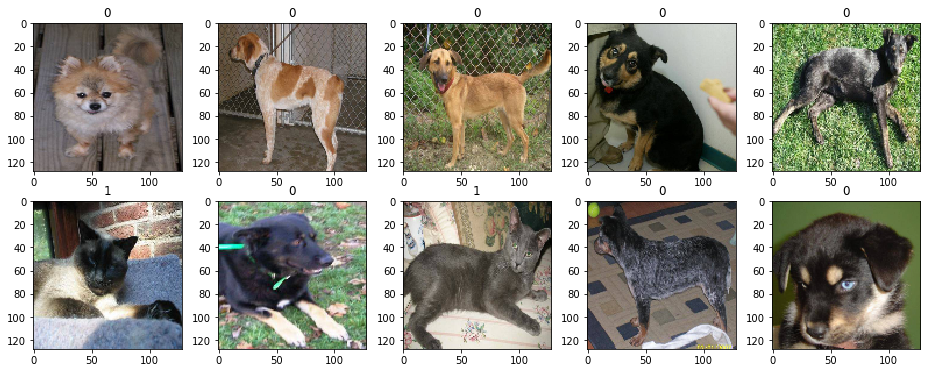

In [109]:
plt.figure(figsize=(16,6))
for i, idx in enumerate(np.random.randint(0,len(resized_images),size=10)):
    plt.subplot(2,5,i+1)
    plt.imshow(resized_images[idx])
    plt.title(labels[idx])
plt.show()

### Histogram of Oriented Gradients (HOG)

http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

Now we can try HOG on those resized images. A typical HOG contain the following steps:
1. *converting an rgb image to a grey image*
2. *(optional) global image normalisation*
3. *computing the gradient image in x and y*
4. *computing gradient histograms*
5. *normalising across blocks*
6. *flattening into a feature vector*

Let's look at a random image and try HOG on it.

In [110]:
i=np.random.randint(len(resized_images))
img=resized_images[i]
lbl=labels[i]

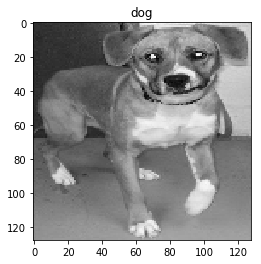

In [111]:
plt.imshow(skimage.color.rgb2gray(img), cmap=plt.cm.gray);
plt.title(lbl2name[lbl])

Play with orientations, pixels_per_cell parameters to see the effect.

In [127]:
h, im = hog(skimage.color.rgb2gray(img), orientations=9,
           pixels_per_cell=(8, 8), cells_per_block=(1, 1),
           visualise=True)

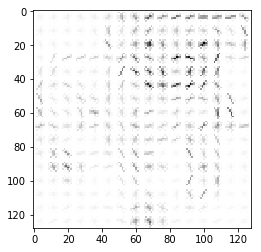

In [128]:
plt.imshow(im, cmap=plt.cm.gray_r);

In [129]:
h.shape

(2304,)

In [130]:
def HOG(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )    
    img = skimage.color.rgb2gray(img)
    return hog(img,orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1))

In [131]:
img_feature=[]
for img in tqdm(resized_images):
    #print '.',
    img_feature.append(HOG(img))

100%|██████████| 200/200 [00:01<00:00, 113.65it/s]


In [132]:
len(img_feature[0])

2048

We have extracted above features from each image. 
The number could be changed by setting different parameters in hog.

Now we can begin our SVM training steps.

In [133]:
X_train, X_test, y_train, y_test = train_test_split(img_feature, labels, test_size=0.5)

In [134]:
clf = SVC(C=100)
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [135]:
clf.score(X_train, y_train)

1.0

In [136]:
clf.score(X_test, y_test)

0.68999999999999995

In [149]:
clf = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=10, max_depth=2)

In [150]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=10, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [151]:
clf.score(X_train, y_train)

1.0

In [152]:
clf.score(X_test, y_test)

0.62

By using HOG and SVM we achieve the above accuracy on the test set. You can also try some other methods.

#### 2. Softmax
Softmax is usually used as a activation function in NN, especially when we use Neural Networks to solve multi-class classification problems.  generalization of the logistic function that "squashes" a K-dimensional vector $\displaystyle \mathbf {z} $  of arbitrary real values to a K-dimensional vector $\displaystyle \sigma (\mathbf {z} )$  of real values in the range [0, 1] that add up to 1.  The function is given by ![function 1][1]
[1]: https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3

As a result, the largest value in the vector is mapped to a value approximates to 1 and the other values are mapped to values approximate to 0.
Here is an example:

Two different implementations are shown below:

In [153]:
def softmax1(z):
    y = np.zeros(len(z))
    for i in range(len(z)):
        y[i] = np.exp(z[i])
    return y/np.sum(y)

In [154]:
def softmax2(x,t=1):
    # x should be 2d: array of vectors
    x1=x-np.max(x,axis=1, keepdims=True)
    x2=np.exp(x1/t)
    x3=x2/np.sum(x2, axis=1, keepdims=True)
    return x3

In [155]:
z = np.array([3, 1, -3])

In [156]:
softmax1(z)

array([ 0.87887824,  0.11894324,  0.00217852])

In [157]:
softmax1(z*1000)

/Users/shahab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/Users/shahab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


array([ nan,  nan,   0.])

In [162]:
softmax2([z*1000], t=100)

array([[  9.99999998e-01,   2.06115362e-09,   8.75651074e-27]])

The figure below can illustrate the function better: 
<img src="https://pic3.zhimg.com/v2-998ddf16795db98b980443db952731c2_r.jpg" width="60%">

In a multi-class classification problem, we expect the Neural Networks to output a probability distribution so that we can choose the most probable class.

#### 3. The Neural Networks
We first take a look at a basic neural network:

Architecture of a Neural Network             | Architecture of a single Neural
:-------------------------:|:-------------------------:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/300px-Colored_neural_network.svg.png" width="80%">| <img src="http://cs231n.github.io/assets/nn1/neuron_model.jpeg " width="70%">

For one way to realize a image classifier with NN, we will treat all the pixels of each image as an input. The simplest neural network (without hidden layers) looks like this:

<img src="https://www.tensorflow.org/images/softmax-regression-scalargraph.png" width="40%">

If we write that out as a equation with matrix, we get:

<img src="https://www.tensorflow.org/images/softmax-regression-vectorequation.png" width="40%">

The parameters we want to optimize by gradient descending are the matrix **W** (weights) and the vector **b** (biases). Then we can realize the model with tensorflow.

##### Activation functions
Besides the softmax in the output layer, we alse need other activation functions to give NN the ability of non-linear model describing. Common activation functions include:

sigmoid  | tanh | relu | leaky-relu 
:-------:|:-------:|:-------:|:-------:
![](http://cs231n.github.io/assets/nn1/sigmoid.jpeg)|![](http://cs231n.github.io/assets/nn1/tanh.jpeg)|![](http://cs231n.github.io/assets/nn1/relu.jpeg)|<img src="http://oexh9rdj7.bkt.clouddn.com/myBlog/posts/NN/LeakyReLU.png" width="70%">

In most of time, we prefer to use relu because sometimes sigmoid and tanh may get satuated and the gradient will get very close to 0.

##### Then we can realize the model with tensorflow.

We start with a simple structure with two hidden layers.

In [ ]:
#!pip install gpustat

In [ ]:
#!gpustat -cup

Setting training parameters.

In [163]:
batch_size = 20
learning_rate = 0.001
n_hidden1 = 256
n_hidden2 = 32
training_iters = 200 #this is too low, use 20000
display_step = 10 #

In [164]:
one_hot_labels=pd.get_dummies(labels).values

In [166]:
train_x, test_x, train_y, test_y = train_test_split(resized_images, one_hot_labels, test_size=0.25)

In [167]:
len(train_x), len(train_y), len(test_x), len(test_y)

(150, 150, 50, 50)

In [168]:
train_x[0].shape, train_y[0].shape, test_x[0].shape, test_y[0].shape

((128, 128, 3), (2,), (128, 128, 3), (2,))

In [169]:
tf.reset_default_graph()

In [170]:
sess=tf.InteractiveSession()

In [171]:
init = tf.global_variables_initializer()

In [172]:
sess.run(init)

Create placeholders for the data:

In [173]:
X = tf.placeholder('float', [None, 128, 128, 3])
y = tf.placeholder('float', [None, 2])

Define input layer

In [174]:
input_layer = tf.reshape(X, [-1, 128*128*3])

Define Weight and Bias variables:

In [175]:
weights = {
    'hidden1': tf.Variable(tf.random_normal([128*128*3,n_hidden1])),
    'hidden2': tf.Variable(tf.random_normal([n_hidden1,n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_hidden2, 2]))
    }
biases = {
    'hidden1': tf.Variable(tf.random_normal([n_hidden1])),
    'hidden2': tf.Variable(tf.random_normal([n_hidden2])),
    'out': tf.Variable(tf.random_normal([2]))
    }

Define the network structure

In [177]:
hidden1 = tf.nn.relu(tf.matmul(input_layer, weights['hidden1'])+biases['hidden1'])
hidden2 = tf.nn.relu(tf.matmul(hidden1, weights['hidden2'])+biases['hidden2'])
out = tf.matmul(hidden2, weights['out'])+biases['out']

Let's look at the weights

In [180]:
sess.run(tf.global_variables_initializer())

In [181]:
weights['hidden1'].eval()

array([[ -8.52710962e-01,   1.43784946e-02,   3.68496686e-01, ...,
          3.82471979e-01,  -2.93307632e-01,  -7.18518615e-01],
       [ -6.66387558e-01,  -1.90920815e-01,   1.04206836e+00, ...,
         -1.19809997e+00,  -1.03758538e+00,  -2.19690159e-01],
       [  1.64120644e-02,  -7.78078437e-01,  -2.13552117e+00, ...,
          2.06547111e-01,  -8.32236335e-02,   5.12867689e-01],
       ..., 
       [ -1.74904990e+00,  -1.32893169e+00,  -5.72319329e-01, ...,
          2.30776966e-02,   2.26743102e-01,  -1.46727943e+00],
       [ -4.01105613e-01,  -7.37163961e-01,  -1.73766923e+00, ...,
          2.16035888e-01,  -1.72172487e-03,  -6.24454379e-01],
       [ -6.36090815e-01,  -1.22958469e+00,  -9.70856071e-01, ...,
         -5.44735551e-01,  -1.24045169e+00,  -5.91799766e-02]], dtype=float32)

Define accuracy:

In [182]:
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, "float"))

In [183]:
sess.run(tf.global_variables_initializer())

In [185]:
accuracy.eval({X:train_x, y:train_y})

0.51333332

Define Loss function:

In [186]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out))

Define an optimizer:

In [187]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [188]:
# with tf.Session() as sess:
# sess.run(init)

In [189]:
sess.run(tf.global_variables_initializer())

let's manually optimize

In [190]:
batch_size

20

In [220]:
batch_idx = np.random.choice(range(len(train_x)), batch_size)
batch_x = np.array(train_x)[batch_idx]
batch_y = np.array(train_y)[batch_idx]

In [221]:
sess.run(optimizer, feed_dict={X: batch_x, y: batch_y})

In [222]:
weights['hidden1'].eval()

array([[-0.20604928,  0.53835565,  0.34654471, ..., -0.15781011,
         0.24246973,  0.84637141],
       [-1.13758814,  1.13167882,  1.07603312, ...,  1.0131464 ,
        -0.58496577, -0.53944927],
       [ 0.53615534,  0.51193208, -0.97140908, ..., -0.07528456,
         0.59473246, -0.66971707],
       ..., 
       [-0.21726117,  0.13298042, -0.29705718, ..., -0.03353409,
         0.20042005,  0.05189629],
       [-1.03896451,  0.33835322, -0.00954728, ...,  1.31895971,
         0.27953422, -0.93178922],
       [-2.49954724, -0.84138495, -0.1119528 , ..., -1.62170172,
        -0.78372455,  1.10672617]], dtype=float32)

In [223]:
out.eval({X:batch_x})

array([[-2606.06420898, -2168.78540039],
       [-1990.6151123 , -3306.61376953],
       [  594.03900146,   847.64331055],
       [  -75.59884644, -1371.9732666 ],
       [  -75.59884644, -1371.9732666 ],
       [ -292.2515564 , -1028.20056152],
       [-2360.73828125, -2242.3425293 ],
       [ -221.87808228,  1129.14001465],
       [  884.62042236, -2116.43774414],
       [   51.93832016,   152.50842285],
       [-1367.77368164, -2383.82470703],
       [ 1028.94714355,   247.64367676],
       [  349.35055542,  -747.55236816],
       [-2211.88427734, -3254.60351562],
       [-2232.42211914, -3674.32177734],
       [-1186.67407227, -1854.00524902],
       [  182.03952026, -3658.68579102],
       [ -520.95477295, -2007.00964355],
       [-1927.51916504, -2579.10595703],
       [ -806.43621826,   149.10522461]], dtype=float32)

In [224]:
accuracy.eval({X:batch_x, y:batch_y})

0.60000002

In [225]:
accuracy.eval({X:test_x, y:test_y})

0.62

In [226]:
# sess.close()

In [227]:
# tf.reset_default_graph()

#### Visualize

In [233]:
!pwd

/Users/shahab/Documents/GitHub/GEC_Lab_Level2


In [236]:
tb_log_dir="/Users/shahab/Documents/GitHub/GEC_Lab_Level2/tflogs/"

In [230]:
if tf.gfile.Exists(tb_log_dir):
    tf.gfile.DeleteRecursively(tb_log_dir) 

In [237]:
graph = tf.get_default_graph().as_graph_def()
summary_writer = tf.summary.FileWriter(tb_log_dir,graph)
# summary_writer = tf.summary.FileWriter('.', sess.graph)
summary_writer.flush()

run tensorboard server:
```
tensorboard  --logdir=[use path you used in summary_writer above]
```

Open this page: http://localhost:6006/#graphs

Put this steps together in a loop

In [251]:
tf.reset_default_graph()
X = tf.placeholder('float', [None, 128, 128, 3])
y = tf.placeholder('float', [None, 2])

input_layer = tf.reshape(X, [-1, 128*128*3])
weights = {
    'hidden1': tf.Variable(tf.random_normal([128*128*3, n_hidden1])),
    'hidden2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_hidden2, 2]))
    }
biases = {
    'hidden1': tf.Variable(tf.random_normal([n_hidden1])),
    'hidden2': tf.Variable(tf.random_normal([n_hidden2])),
    'out': tf.Variable(tf.random_normal([2]))
    }

hidden1 = tf.nn.relu(tf.matmul(input_layer, weights['hidden1'])+biases['hidden1'])
hidden2 = tf.nn.relu(tf.matmul(hidden1, weights['hidden2'])+biases['hidden2'])
out = tf.matmul(hidden2, weights['out'])+biases['out']

correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, "float"))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [252]:
init = tf.global_variables_initializer()
sess=tf.InteractiveSession()

In [ ]:
sess.run(init)
for step in range(training_iters):
        #take a [random] batch
        batch_idx = np.random.choice(range(len(train_x)), batch_size)
        batch_x = np.array(train_x)[batch_idx]
        batch_y = np.array(train_y)[batch_idx]
        
        #run optimization step
        sess.run(optimizer, feed_dict={X: batch_x, y: batch_y})
        
        #this is for tensorboard
        tf.summary.histogram('output', out)
        tf.summary.scalar('loss', loss)
        tf.summary.scalar('train_accuracy', accuracy)

        #display progress
        if (step+1)%display_step == 0:
            b_loss, b_acc = sess.run([loss, accuracy], feed_dict={X: batch_x, y: batch_y})
            t_loss, t_acc = sess.run([loss, accuracy], feed_dict={X: test_x, y: test_y})
            print('Iter '+str(step+1)+', batch loss = '+str(b_loss)+', bacth accuracy = '+str(b_acc)+
                 ', test loss = '+str(t_loss)+', test accuracy = '+str(t_acc))
            
            summary = tf.summary.merge_all()

            summary_str = sess.run(summary, feed_dict={X: batch_x, y: batch_y})
            summary_writer.add_summary(summary_str, step)
            
summary_writer.flush()    
print('Training finished!')

In [250]:
sess.close()

When training a NN, our first goal is make the NN proper and complicated enough to describe a complicated problem (To solve the underfitting problem). (e.g. get the batch accuracy up to 0.90 and the test accuracy at some 0.60.) After that, we should solve the overfitting problem.

In the past training, we got the loss down to 0.69 on a batch. But it is far from small enough. We may include more hidden layers or convolutional layers in our network.

<span style="color:blue">Let's assume our model have achieved a very high score on the trainset but a raletively low score on the testset.</span> What should we do now?

##### To deal with overfitting
There are several ways to do that.

* **Regularization (L2)**

L2 Regularization keeps the parameters (weights, biases, etc.) from being too large by adding a penalty of large parameters (L2 norm) in the loss function. 

For example:

In [246]:
reg_lambda = 0.1
regularizer = tf.nn.l2_loss(weights['hidden1'])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out))+reg_lambda*regularizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

You need to continue adjusting the reg_lambda to make a trade-off between overfitting and underfitting.

* **Regularization (Dropout)**

Dropout will randomly disable the output of a proportion of neurals. It also keeps the parameters (weights, biases, etc.) from being too large (if some neurals have large parameters, once they are disabled, the loss will get very high).

For example:

In [ ]:
input_layer = tf.reshape(X, [-1, 128*128*3])
hidden1 = tf.nn.relu(tf.matmul(input_layer, weights['hidden1'])+biases['hidden1'])
hidden1 = tf.nn.dropout(hidden1, keep_prob=0.8) # 20% of the neurals will be dropout
hidden2 = tf.nn.relu(tf.matmul(hidden1, weights['hidden2'])+biases['hidden2'])
hidden2 = tf.nn.dropout(hidden2, keep_prob=0.8)
out = tf.matmul(hidden2, weights['out'])+biases['out']

* **Batch Normalization**

Batch Normalization means to shift inputs to zero-mean and unit variance for each batch. It solves a problem called internal covariate shift.

Internal covariate shift refers to covariate shift occurring within a neural network, i.e. going from layer 2 to layer 3. This happens because, as the network learns and the weights are updated, the distribution of outputs of a specific layer in the network changes. This forces the higher layers to adapt to that drift, which slows down learning.

For example:

In [ ]:
input_layer = tf.reshape(X, [-1, 128*128*3])
hidden1 = tf.nn.relu(tf.matmul(input_layer, weights['hidden1'])+biases['hidden1'])
hidden1 = tf.nn.dropout(hidden1, keep_prob=0.8) # 20% of the neurals will be dropout
hidden1 = tf.contrib.layers.batch_norm(hidden1)
hidden2 = tf.nn.relu(tf.matmul(hidden1, weights['hidden2'])+biases['hidden2'])
hidden2 = tf.nn.dropout(hidden2, keep_prob=0.8)
hidden2 = tf.contrib.layers.batch_norm(hidden2)
out = tf.matmul(hidden2, weights['out'])+biases['out']

### Q: How can we use Keras for this problem?

In [ ]:
#Change this code to work with Cat-Dog data.
model = Sequential()
model.add(Convolution2D(5, 20, 20, activation='relu', input_shape=(128,128,3)))
model.add(Convolution2D(7, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X.reshape(len(X),128,128,1), y, 
          batch_size=32, nb_epoch=10, verbose=1)

### Q: How can we use HOG features in our NN?